<a href="https://colab.research.google.com/github/GrimmerJR/Research/blob/main/SPX_and_BTC_Rolling_Correlation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import random

##Data Loading and Preprocessing
In this section, we use Yahoo Finance to download the adjusted closing prices for Bitcoin and the S&P 500. After aligning the data by date, any missing values are dropped. This ensures our dataset is clean before processing.

In [16]:
# Download data for Bitcoin (BTC-USD) and S&P 500 (^GSPC) from Yahoo Finance
start_date = '2019-01-01'
end_date = '2024-09-13'
bitcoin_data = yf.download('BTC-USD', start=start_date, end=end_date)['Adj Close']
spx_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']

# Align the data by date and drop missing values
data_btc_spx = pd.concat([bitcoin_data, spx_data], axis=1)
data_btc_spx.columns = ['Bitcoin', 'S&P 500']
data_btc_spx.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##Pearson and Spearman Correlation Calculation
Before diving into the LSTM model for time-series forecasting, it's crucial to understand the relationship between Bitcoin and S&P 500 over the entire timeframe. Pearson correlation will measure the linear correlation, while Spearman correlation captures monotonic relationships. This provides an initial insight into how these assets move together in general.

In [17]:
# Calculate Pearson and Spearman correlations between Bitcoin and S&P 500
pearson_corr = data_btc_spx['Bitcoin'].corr(data_btc_spx['S&P 500'], method='pearson')
spearman_corr = data_btc_spx['Bitcoin'].corr(data_btc_spx['S&P 500'], method='spearman')

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: 0.8932708432672053
Spearman Correlation: 0.9104268347069422


## Rolling Correlation Calculation
A rolling correlation allows us to observe how the relationship between Bitcoin and S&P 500 changes over time. Here, we calculate a rolling correlation with a window size of 30 days. This will be the target variable for our LSTM model later.

In [18]:
# Calculate rolling correlation (30-day window) between Bitcoin and S&P 500
window_size = 30
data_btc_spx['Rolling_Correlation'] = data_btc_spx['Bitcoin'].rolling(window=window_size).corr(data_btc_spx['S&P 500'])

# Drop missing values after calculating rolling correlation
data_btc_spx.dropna(inplace=True)

##Data Normalization
The LSTM model requires data to be normalized within a specific range. Here, we use MinMaxScaler to scale the rolling correlation values between -1 and 1, which is ideal for time-series modeling

In [19]:
# Normalize the data for LSTM model in the range of -1 to 1 (appropriate for correlation)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data_btc_spx['Rolling_Correlation'].values.reshape(-1, 1))

##Data Preparation for LSTM
We create sequences of past 60 timesteps (X) to predict the next timestep (Y). This reshaping is essential for LSTM input as it operates on sequences of data. The training and test sets are then split, with 80% used for training.

In [20]:
# Create dataset for LSTM model where X is past 60 timesteps and Y is the next timestep
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# Reshape data to 3D array for LSTM [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

##LSTM Model Architecture
This section builds an LSTM model with two LSTM layers followed by Dropout layers to prevent overfitting. The architecture includes 100 units in the first LSTM layer and 50 units in the second. The final Dense layer outputs one value, the predicted rolling correlation.

In [21]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add Dropout layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(units=25))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##Model Training
Here we compile the model using the Adam optimizer and mean squared error (MSE) as the loss function. We train the model for 25 epochs with a batch size of 64.

In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=64, epochs=25)

Epoch 1/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.1953
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0637
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0400
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0359
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0286
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0279
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0241
Epoch 8/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0240
Epoch 9/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0196
Epoch 10/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0184
Epoch 11/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.0168
Epoch 12/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0155
Epoch 13/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0145
Epoch 14/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 0.0139
Epoch 15/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - lo

##Model Evaluation
Once the model is trained, we evaluate its performance using the test dataset. The Root Mean Squared Error (RMSE) is calculated to measure prediction accuracy.

In [23]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate model accuracy using Root Mean Squared Error (RMSE)
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
RMSE: 0.0848843358258977


##Visualizing Predictions
The results are visualized using seaborn. We plot both the actual rolling correlation and the model's predicted correlation for comparison.

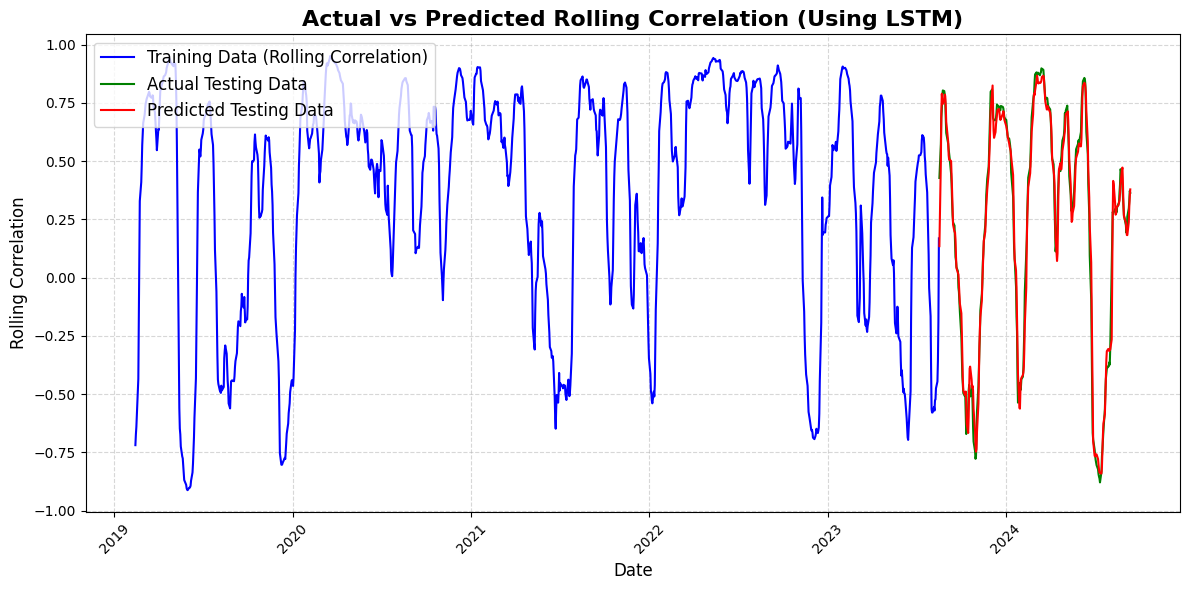

In [24]:
# Prepare data for plotting
train_data = data_btc_spx['Rolling_Correlation'][:train_size + time_step]
test_data = data_btc_spx['Rolling_Correlation'][train_size + time_step:]
test_data = pd.DataFrame(test_data, columns=['Rolling_Correlation'])
test_data['Predictions'] = predictions

# Plot the results using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data, label='Training Data (Rolling Correlation)', color='blue')
sns.lineplot(x=test_data.index, y=test_data['Rolling_Correlation'], label='Actual Testing Data', color='green')
sns.lineplot(x=test_data.index, y=test_data['Predictions'], label='Predicted Testing Data', color='red')
plt.title('Actual vs Predicted Rolling Correlation (Using LSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rolling Correlation', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


##Future Prediction
Finally, we use the trained model to forecast the rolling correlation for the next 7 days. This is useful for making short-term predictions of asset relationships.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


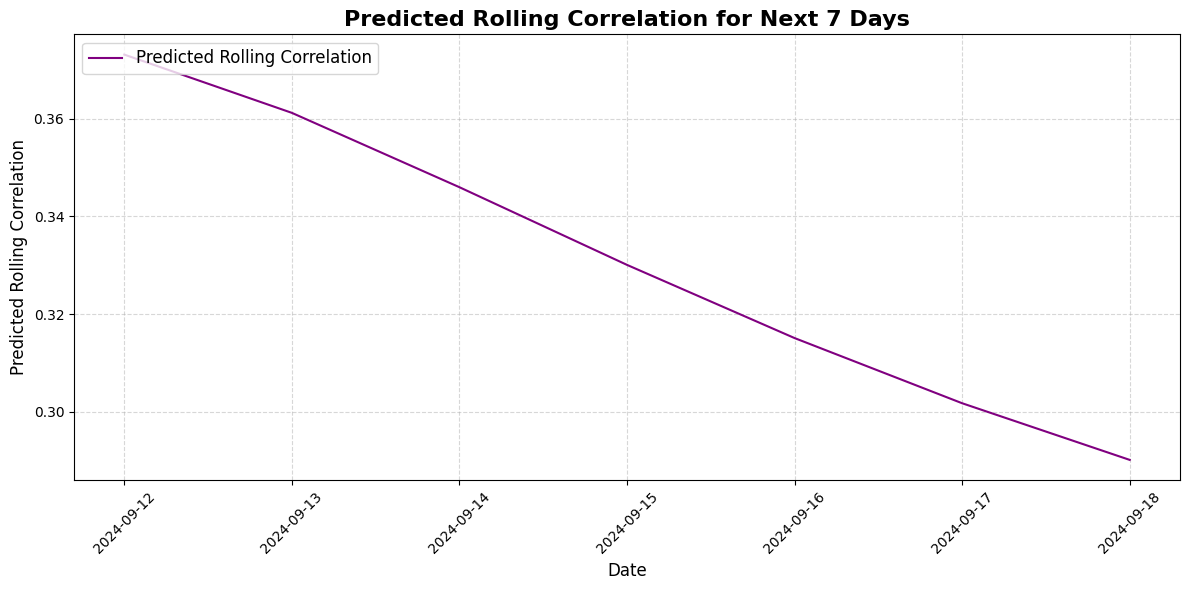

In [25]:
# Future Prediction (7 Days Ahead)
future_predictions = []
last_60_days = scaled_data[-time_step:]  # Use the last 60 days for prediction
future_input = last_60_days.reshape(1, time_step, 1)

for _ in range(7):  # Predict for the next 7 days
    future_pred = model.predict(future_input)
    future_predictions.append(future_pred[0][0])  # Store the predicted value

    # Shift the window to include the latest prediction
    future_pred_reshaped = future_pred.reshape(1, 1, 1)  # Reshape future_pred to match input dimensions
    future_input = np.append(future_input[:, 1:, :], future_pred_reshaped, axis=1)

# Transform the predicted values back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a future date range for the next 7 days
last_date = data_btc_spx.index[-1]
future_dates = pd.date_range(last_date, periods=7, freq='D')

# Create DataFrame for future predictions
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted_Rolling_Correlation'])

# Plot future predictions
plt.figure(figsize=(12, 6))
sns.lineplot(x=future_df.index, y=future_df['Predicted_Rolling_Correlation'], label='Predicted Rolling Correlation', color='purple')
plt.title('Predicted Rolling Correlation for Next 7 Days', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Rolling Correlation', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()